In [1]:
import numpy as np
import pandas as pd 
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import plot_roc_curve, roc_auc_score
from scipy.stats import ks_2samp

In [2]:
df_all = pd.read_csv("train.csv")
df_signal = df_all[df_all['signal'] == 1]
df_background = df_all[df_all['signal'] == 0];
#df_all.info()

[1.3829496375774648e-169, 'VertexChi2']
[7.713193176030109e-138, 'isolationa']
[3.4703826247911382e-74, 'isolationb']
[6.854359357263299e-67, 'p0_IPSig']
[7.724271704158086e-63, 'CDF2']
[5.369604939247967e-61, 'isolationc']
[1.0098828890376335e-56, 'CDF3']
[1.489709682990678e-52, 'DOCAone']
[1.810016451401861e-52, 'LifeTime']
[8.112289445631904e-46, 'IP_p1p2']
[2.32908976702074e-45, 'DOCAtwo']
[3.3141770732441054e-41, 'p0_IP']
[4.2234647975138974e-39, 'pt']
[8.39554348092537e-35, 'DOCAthree']
[2.237177537627148e-33, 'p1_pt']
[1.984325413365685e-22, 'FlightDistance']
[3.296496054422018e-17, 'CDF1']
[2.55351295663786e-15, 'p0_pt']
[1.7584104172740922e-09, 'IP_p0p2']
[2.412261834727758e-09, 'p1_eta']
[4.480768756032205e-09, 'p2_eta']
[4.5716822549835e-09, 'p1_IPSig']
[6.124802887086389e-09, 'FlightDistanceError']
[5.745821030078702e-07, 'p0_eta']
[0.00016630989516475125, 'p2_pt']
[0.00021380395190706558, 'p2_IPSig']
[0.0006363734032619472, 'p1_p']
[0.013448963630375732, 'p0_p']
[0.0233938

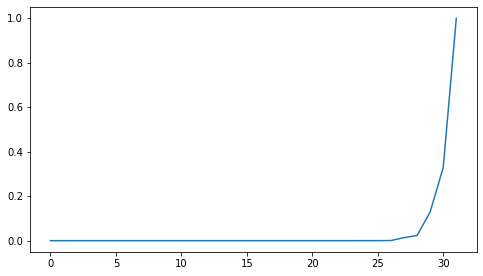

In [3]:
tag_list = list(df_all.columns.values)
tag_list.remove('signal')
vals = []
for tag in tag_list:
    v = ks_2samp(df_signal[tag], df_background[tag])
    vals.append([float(v[1])]+[tag])
vals.sort()
X = np.zeros(len(vals))
i = 0
for v in vals:
    X[i] = v[0]
    print(v)
    i += 1
plt.figure(0, figsize= (8,4.5))
plt.plot(np.arange(X.shape[0]), X)
plt.show()

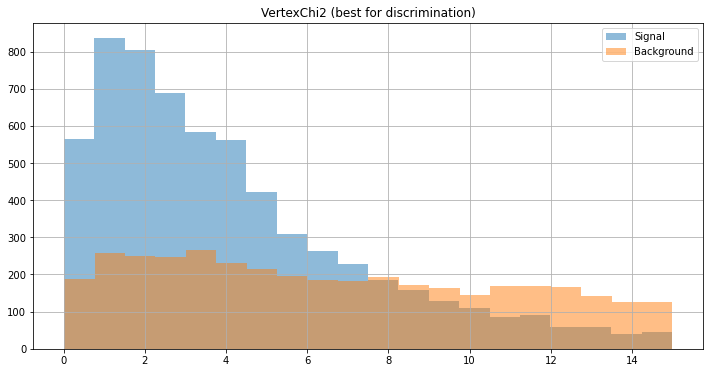

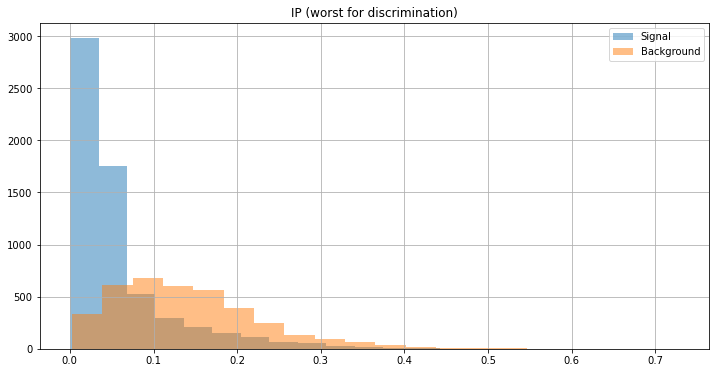

In [4]:
%matplotlib inline
plt.figure(0, figsize=(12,6))
plt.hist(df_signal[vals[0][1]], alpha= 0.5, bins= 20, label="Signal")
plt.hist(df_background[vals[0][1]], alpha= 0.5, bins= 20, label="Background")
plt.title(vals[0][1] + " (best for discrimination)")
plt.grid()
plt.legend()

plt.figure(1, figsize=(12,6))
plt.hist(df_signal[vals[-1][1]], alpha= 0.5, bins= 20, label="Signal")
plt.hist(df_background[vals[-1][1]], alpha= 0.5, bins= 20, label="Background")
plt.title(vals[-1][1] + " (worst for discrimination)")
plt.grid()
plt.legend()

In [5]:
def fitBDT(df, cols, tag, ntrees= 500, ndepth= 15):
    """
    Fits a boosted decision tree to cols of df to reproduce tag of df
    
    Parameters:
    -----------
    df: Pandas Dataframe containing all data required for fitting

    cols: a list of strings, describing the input columns with which to fir the BDT

    tag: a string describing the column for which to fit 

    ntrees: integer, depth of the AdaBoostRegressor

    ndepth: integer, depth of the DecisionTreeRegressor

    Returns:
    --------
    AdaBoostClassifier (Boosted Decision Tree)
    """
    BDT = AdaBoostClassifier(n_estimators=ntrees, base_estimator=DecisionTreeClassifier(max_depth=ndepth))
    BDT.fit(df[cols], df[tag])
    return BDT

In [6]:
 #  you can ignore this, i was just curious if i could do something like this 
def optimizeBDT(df_train, cols, tag, df_test, limits, eval_func, verbosity = 0, min_improvement_score_diff= 0.001):
    """
    Faster optimization of BDT by bisection method, always first trying the lower parameter bounds, as those take less time to train. 

    Parameters:
    -----------
    df_train: dataframe with training data

    df_test: dataframe with data used for evaluating the BDT

    limits: (2,2)- shaped np array (dtype=int) with lower and upper bound for 1. ntrees and 2. ndepth

    eval_func: function used for evaluation

    returns: 
    --------
    BDT and prints out why it halted if verbosity is >= 1 (default 0)
    """
    a = [limits[0, 0], limits[1, 0]]  # ntrees_min, ndepth_min
    b = [np.floor((limits[0,0]+limits[0,1])/2), np.floor((limits[1,0]+limits[1,1])/2)]  # ntrees_max, ndepth_max
    BDT_lower = fitBDT(df_train, cols, tag, ntrees= int(a[0]), ndepth= int(a[1]))  # ntrees_min, ndepth_min 
    BDT_upper = fitBDT(df_train, cols, tag, ntrees= int(b[0]), ndepth= int(b[1]))  # ntrres_max, ndepth_max 
    unchangecount = 0
    A = 0
    B = 0
    return_upper = True
    if verbosity > 1:
        print("limits")
        print(limits)
        print("a")
        print(a)
        print("b")
        print(b)
    while True:
        for hyppara in range(2):
            if verbosity>1: print("checking parameters ntrees = [",a[0],",",b[0],"] and ndepth = [",a[1],",",b[1],"] for ","ntrees" if hyppara==0 else "ndepth")
            A = eval_func(BDT_lower, df_test, cols, tag)
            B = eval_func(BDT_upper, df_test, cols, tag)
            
            if B > A or (not (B > A) and unchangecount >=2):
                return_upper = True
                if verbosity>1: 
                    print("upper bounds were better. (", b[0], ",", b[1], ") with ", B)
                    if unchangecount >= 2: print("veto by unchangecount")
                tmp_a = b[hyppara] 
                tmp_b = np.floor((b[hyppara]+limits[hyppara,1])/2)  # compute new limits by lower-half bisection
                if verbosity > 1: print("training new with ntrees = ", tmp_b if hyppara == 0 else b[0], " and ndepth = ", tmp_b if hyppara == 1 else b[1])
                BDT_new = fitBDT(df_train, cols, tag, ntrees= int(tmp_a if hyppara == 0 else b[0]), ndepth= int(tmp_b if hyppara == 1 else b[1]))
                C = eval_func(BDT_new, df_test, cols, tag)
                if C > B:  # accept change
                    if verbosity>1: print("new bounds were better. score: ", C)
                    BDT_lower = BDT_upper
                    BDT_upper = BDT_new
                    a[hyppara] = tmp_a
                    b[hyppara] = tmp_b
                    unchangecount = 0
                else:  # reject and check for return
                    if verbosity>1: print("new bounds were not better. score: ", C)
                    unchangecount +=1
                    if unchangecount == 4: 
                        if verbosity>0: print("returned as bounds did not change for either parameter, either check limits or the optimum was found")
                        return BDT_upper
            else:
                return_upper = False
                if verbosity>1: 
                    print("lower bounds were better. (", a[0] , ",", a[1] , ") with ", A)
                    if unchangecount >= 2: print("veto by unchangecount")
                tmp_b = np.floor((b[hyppara]+a[hyppara])/2)  # compute new limits by lower-half bisection
                if verbosity > 1: print("training new with ntrees = ", tmp_b if hyppara == 0 else a[0], " and ndepth = ", tmp_b if hyppara == 1 else a[1])
                BDT_new = fitBDT(df_train, cols, tag, ntrees= int(tmp_b if hyppara == 0 else a[0]), ndepth= int(tmp_b if hyppara == 1 else a[1]))
                C = eval_func(BDT_new, df_test, cols, tag)
                if C > A:  # accept changes
                    if verbosity>1: print("new bounds were better. score: ", C)
                    BDT_upper = BDT_new
                    b[hyppara] = tmp_b
                    unchangecount = 0
                else:  # reject and check for return
                    if verbosity>1: print("new bounds were not better. score: ", C)
                    unchangecount +=1
                    if unchangecount == 4: 
                        if verbosity>0: print("returned as bounds did not change for either parameter, either check limits or the optimum was found")
                        return BDT_lower
            if verbosity>1: print("")
        if np.abs(A-B)<min_improvement_score_diff:  # if the difference in quality enhancement is too low, cancel search early as the improvements deminish
            if verbosity>0: print("canceled early, as BDTs did not get better fast enough, local optimum probably close.")
            return BDT_upper if return_upper else BDT_lower

In [7]:
def gird_search_BDT(df_train, cols, tag, df_test, limits, eval_func, samples, verbosity=0):
    """
    grid searches for best BDT within the limits

    Parameters:
    -----------
    df_train: dataframe with training data

    df_test: dataframe with data used for evaluating the BDT

    limits: (2,2)- shaped np array (dtype=int) with lower and upper bound for 1. ntrees and 2. ndepth

    eval_func: function used for evaluation

    samples: (2,) shaped array which describes the ammount of samples to take between limits for 1. ntrees and 2. ndepth

    returns: 
    --------
    BDT
    """
    BDT_best = None
    maxscore = 0
    for nt in range(limits[0,0], limits[0,1], int(np.floor((limits[0,0]+limits[0,1])/samples[0]))):
        for nd in range(limits[1,0], limits[1,1], int(np.floor((limits[1,0]+limits[1,1])/samples[1]))):
            if verbosity>0: print("Trying new BDT with ntrees:", nt, " and ndepth:", nd)
            BDT = fitBDT(df_train, cols, tag, ntrees= int(nt), ndepth= int(nd))
            k = eval_func(BDT, df_test, cols, tag)
            if k > maxscore: 
                BDT_best = BDT
                maxscore = k
                if verbosity>0: print("This had the best score so far: ", maxscore)
    return BDT_best

In [8]:
def simple_BDT_eval(BDT, df, cols, tag):
    """returns accuracy of BDT in predicting tag of df, given list of cols"""
    pred = BDT.predict(df[cols])
    diff = (pred - df[tag])
    variation = diff.abs().mean()
    return 1- variation  # needed to make smaller variation have a better score

  i got the best results when including all colums. 

In [9]:
tag_list = list(np.array(vals)[:,1])
goal = 'signal'
df_train, df_test = train_test_split(df_all, test_size=0.25)
limits = np.array([[100, 1000], [10, 100]])
print("optimize BDT:")
print("----------------------------------------")
%time BDT_opt = optimizeBDT(df_train, tag_list, goal, df_test, limits, simple_BDT_eval, verbosity=2)
print("")
print("Grid search BDT:")
print("----------------------------------------")
%time BDT_gs = gird_search_BDT(df_train, tag_list, goal, df_test, limits, simple_BDT_eval, [10,10], verbosity=2)
print("")
print("(optimize) test of performance: " , simple_BDT_eval(BDT_opt, df_test, tag_list, goal))
print("(grid_s..) test of performance: " , simple_BDT_eval(BDT_gs, df_test, tag_list, goal))

optimize BDT:
----------------------------------------
limits
[[ 100 1000]
 [  10  100]]
a
[100, 10]
b
[550.0, 55.0]
checking parameters ntrees = [ 100 , 550.0 ] and ndepth = [ 10 , 55.0 ] for  ntrees
lower bounds were better. ( 100 , 10 ) with  0.8092762894842063
training new with ntrees =  325.0  and ndepth =  10
new bounds were better. score:  0.8204718112754898

checking parameters ntrees = [ 100 , 325.0 ] and ndepth = [ 10 , 55.0 ] for  ndepth
upper bounds were better. ( 325.0 , 55.0 ) with  0.8204718112754898
training new with ntrees =  325.0  and ndepth =  77.0
new bounds were not better. score:  0.7369052379048381

checking parameters ntrees = [ 100 , 325.0 ] and ndepth = [ 10 , 55.0 ] for  ntrees
upper bounds were better. ( 325.0 , 55.0 ) with  0.8204718112754898
training new with ntrees =  662.0  and ndepth =  55.0
new bounds were not better. score:  0.7305077968812475

checking parameters ntrees = [ 100 , 325.0 ] and ndepth = [ 10 , 55.0 ] for  ndepth
upper bounds were bette

 ## Here already with improved BDTs

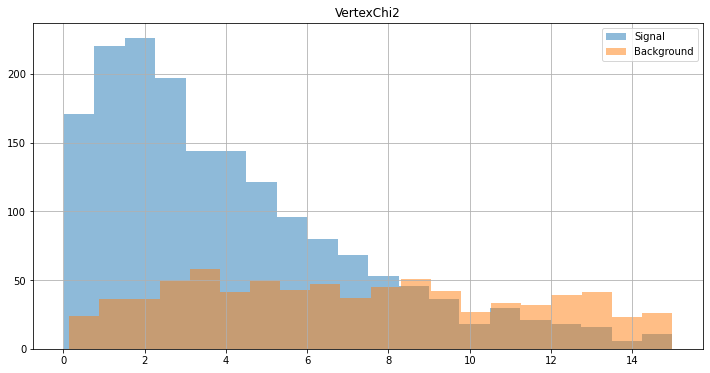

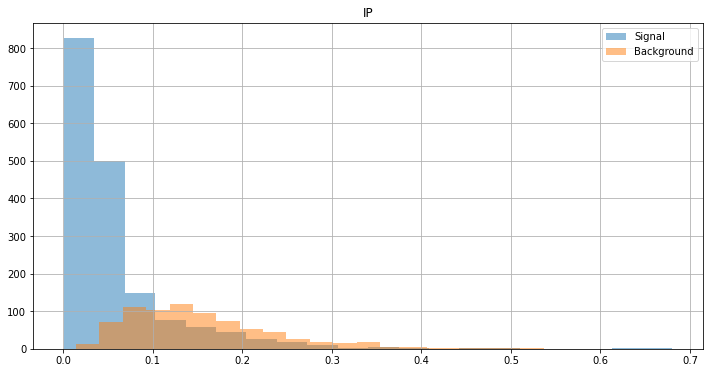

In [10]:
%matplotlib inline

df_pred = df_test.copy(deep=True)
df_pred['pred'] = BDT_gs.predict(df_pred[tag_list])

df_pred_signal = df_pred[df_pred['pred'] == 1]
df_pred_background = df_pred[df_pred['pred'] == 0]

plt.figure(0, figsize=(12,6))
plt.hist(df_pred_signal[vals[0][1]], alpha= 0.5, bins= 20, label="Signal")
plt.hist(df_pred_background[vals[0][1]], alpha= 0.5, bins= 20, label="Background")
plt.title(vals[0][1] )
plt.grid()
plt.legend()

plt.figure(1, figsize=(12,6))
plt.hist(df_pred_signal[vals[-1][1]], alpha= 0.5, bins= 20, label="Signal")
plt.hist(df_pred_background[vals[-1][1]], alpha= 0.5, bins= 20, label="Background")
plt.title(vals[-1][1] )
plt.grid()
plt.legend()

plt.show()

AUC of ROC curve:  0.7929892278700567


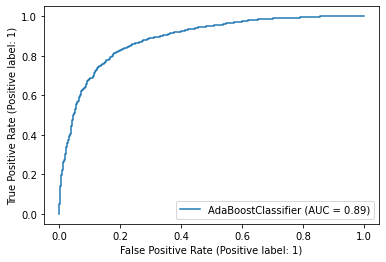

In [11]:
%matplotlib inline
plot_roc_curve(BDT_opt, df_test[tag_list], df_test[goal])
print("AUC of ROC curve: ", roc_auc_score(df_test[goal], BDT_opt.predict(df_test[tag_list])))
plt.show()